In [ ]:
# ! pip install spikeinterface
# ! pip install probeinterface

In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import datajoint as dj
import spikeinterface
import spikeinterface.extractors as se
from workflow.pipeline import ephys, probe
from workflow.utils.ingestion_utils import El2ROW

[2023-11-17 18:07:19,697][INFO]: Connecting utah-worker@db.datajoint.com:3306
[2023-11-17 18:07:20,080][INFO]: Connected utah-worker@db.datajoint.com:3306


### Read data

In [ ]:
key = {
    "organoid_id": "O17",
    "experiment_start_time": datetime(2023, 7, 13, 18, 15),
    "insertion_number": 0,
    "start_time": datetime(2023, 7, 13, 18, 30),
    "end_time": datetime(2023, 7, 13, 18, 35),
}

query = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
)

file_times, files = query.fetch("file_time", "file", order_by="file_time")

# Read the first file
# recording = se.read_intan(files[0], stream_name="RHD2000 amplifier channel")
# recording.get_traces(return_scaled=True)  # return values in uV
# recording.get_times() # get timestamps
# recording.get_time_info()  # {'sampling_frequency': 20000.0, 't_start': None, 'time_vector': None}
# recording.neo_reader
# recording.has_time_vector()  # false
# recording.sampling_frequency

In [ ]:
# Concatenate the data
stream_name = "RHD2000 amplifier channel"
recording = None
t_start = file_times[0]
for file in files:
    if not recording:
        recording =se.read_intan(file, stream_name=stream_name)
    else:
        recording = si.concatenate_recordings([recording, se.read_intan(file, stream_name=stream_name)])
        
recording

ConcatenateSegmentRecording: 128 channels - 20.0kHz - 1 segments - 4,800,000 samples 
                             240.00s (4.00 minutes) - uint16 dtype - 1.14 GiB

### Generate probe

In [ ]:
from probeinterface import Probe, get_probe
from probeinterface.plotting import plot_probe
from probeinterface import generate_linear_probe

In [ ]:
# Get probe info
probe_info = (ephys.EphysSessionProbe & key).fetch1()
probe_type = (probe.Probe & {"probe": probe_info["probe"]}).fetch1(
    "probe_type"
) # 'A1x32-6mm-100-177-H32_21mm'
manufacturer = 'neuronexus'

electrode_query = probe.ElectrodeConfig.Electrode & (
    probe.ElectrodeConfig & {"probe_type": probe_type}
)
number_of_electrodes = len(electrode_query)
unused_electrodes = [elec for elec in range(number_of_electrodes) if elec not in probe_info["used_electrodes"]]

# Filter for used electrodes. If probe_info["used_electrodes"] is None, it means all electrodes were used.
if probe_info["used_electrodes"] is not None:
    electrode_query &= (
        f'electrode IN {tuple(probe_info["used_electrodes"])}'
    )
    
electrode_df = electrode_query.fetch(format="frame").reset_index()

channel_to_electrode_map = dict(
    zip(electrode_df["channel"], electrode_df["electrode"])
)

channel_to_electrode_map = {
    f'{probe_info["port_id"]}-{int(channel):03d}': electrode
    for channel, electrode in channel_to_electrode_map.items()
}

lfp_indices = np.sort(np.array(electrode_query.fetch("channel"), dtype=int))
print(channel_to_electrode_map)

{'A-019': 0, 'A-004': 1, 'A-018': 2, 'A-005': 3, 'A-017': 4, 'A-006': 5, 'A-031': 6, 'A-008': 7, 'A-030': 8, 'A-009': 9, 'A-029': 10, 'A-010': 11, 'A-020': 12, 'A-003': 13, 'A-021': 14, 'A-002': 15, 'A-022': 16, 'A-001': 17, 'A-024': 18, 'A-015': 19, 'A-025': 20, 'A-014': 21}


,x,y,contact_shapes,radius,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,0.0,0.0,circle,15.0,,0,19,um,1.0,0.0,0.0,1.0
1,0.0,100.0,circle,15.0,,1,4,um,1.0,0.0,0.0,1.0
2,0.0,200.0,circle,15.0,,2,18,um,1.0,0.0,0.0,1.0
3,0.0,300.0,circle,15.0,,3,5,um,1.0,0.0,0.0,1.0
4,0.0,400.0,circle,15.0,,4,17,um,1.0,0.0,0.0,1.0
5,0.0,500.0,circle,15.0,,5,6,um,1.0,0.0,0.0,1.0
6,0.0,600.0,circle,15.0,,6,31,um,1.0,0.0,0.0,1.0
7,0.0,700.0,circle,15.0,,7,8,um,1.0,0.0,0.0,1.0
8,0.0,800.0,circle,15.0,,8,30,um,1.0,0.0,0.0,1.0
9,0.0,900.0,circle,15.0,,9,9,um,1.0,0.0,0.0,1.0


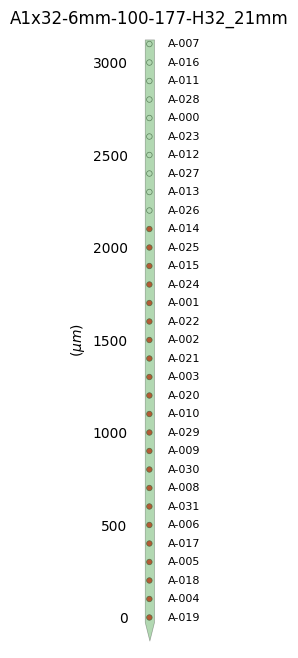

In [ ]:
# Plot the probe
fig, ax = plt.subplots(figsize=(8, 8))

# Create a session probe
linear_probe = generate_linear_probe(num_elec=32, ypitch=100, contact_shape_params={'radius': 15})
linear_probe.set_device_channel_indices(El2ROW)

contact_colors = ['r' if e in probe_info["used_electrodes"] else 'w' for e in range(number_of_electrodes)]  # red for used channels

plot_probe(linear_probe, ax=ax, contacts_colors=contact_colors)
[spine.set_visible(False) for spine in ax.spines.values()]
ax.yaxis.set_ticks_position('none')  # Remove y-axis tick marks
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("($\\mu m$)", fontsize=10)
ax.set_title(probe_type)

contact_positions = linear_probe.contact_positions
device_channel_indices = [f"{probe_info['port_id']}-{ch:03}" for ch in linear_probe.device_channel_indices]

for (x, y), txt in zip(contact_positions, device_channel_indices):
    ax.text(x + 100, y, txt, va="center", fontsize=8)

recording = recording.set_probe(linear_probe)
linear_probe.to_dataframe(complete=True) 

#### Preprocessing

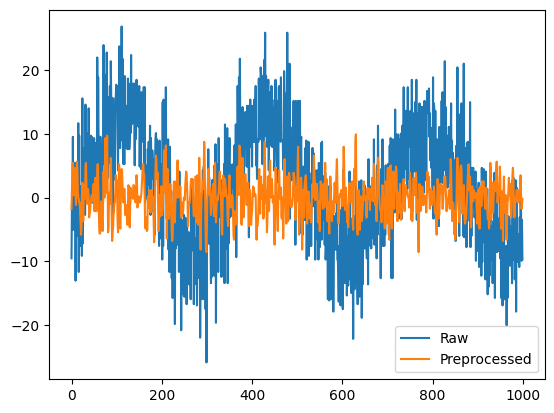

In [ ]:
from spikeinterface import preprocessing

recording = recording.remove_channels(
    remove_channel_ids=np.array([str(elec) for elec in unused_electrodes])
)  # Remove unused electrodes
recording_f = si.preprocessing.bandpass_filter(recording=recording, freq_min=300, freq_max=6000)
recording_cmr = si.preprocessing.common_reference(recording=recording_f, operator="median")

trace_raw = recording.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)
trace_preprocessed = recording_cmr.get_traces(start_frame=100_000, end_frame=101_000, return_scaled=True)

plt.plot(trace_raw [:, 0], label='Raw')
plt.plot(trace_preprocessed[:, 0], label='Preprocessed')
plt.legend()
plt.show()

### Run sorter

In [ ]:
from spikeinterface.full import run_sorter

#### spiking circus 2

In [ ]:
# !pip install hdbscan
# !pip install spikeinterface
# !pip install numba

### Run sorter

In [ ]:
from spikeinterface.full import run_sorter

#### spiking circus 2

In [ ]:
# !pip install hdbscan
# !pip install spikeinterface
# !pip install numba

In [ ]:
sorting = run_sorter(recording=recording_cmr, sorter_name='spykingcircus2')
sorting

NumpyFolderSorting: 9 units - 1 segments - 20.0kHz

#### Kilosort2_5

In [ ]:
# !pip install docker
# !pip install cuda-python

In [ ]:
sorting_kilosort = run_sorter(
    sorter_name="kilosort2_5",
    recording=recording_cmr,
    output_folder="/tmp/kilosort2",
    docker_image=f"spikeinterface/{sorter_name}-compiled-base:latest",
)

#### Kilosort2_5

In [ ]:
# !pip install docker
# !pip install cuda-python

In [ ]:
# sorter_name = "kilosort2_5" 
# sorting = run_sorter(
#     sorter_name=sorter_name,
#     recording=recording_cmr,
#     output_folder="/tmp/kilosort2",
#     docker_image=f"spikeinterface/{sorter_name}-compiled-base:latest",
# )